In [120]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import plot_roc_curve, roc_auc_score, roc_curve


First we are going to load the dataset, which is the accepted files from The Lending Club published in Kaggle data science contest platform as public pseudonymised files in compressed csv format. The information can be downloaded from https://www.kaggle.com/datasets/wordsforthewise/lending-club?resource=download

In [81]:
df=pd.read_csv('accepted_2007_to_2018Q4.csv.gz', compression='gzip')
df.info() # We can see that our data has 2.26 million observations with 151 variables

c:\Users\jjsal\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260701 entries, 0 to 2260700
Columns: 151 entries, id to settlement_term
dtypes: float64(113), object(38)
memory usage: 2.5+ GB


In [82]:
df.head(5)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


### Time span of the dataset

Let's start by analising the colum `issue_d` which is the month of funding. This will enable us to understand how the credits are spread over time. Let's see how this column is formatted.

In [83]:
df.issue_d.describe()

count      2260668
unique         139
top       Mar-2016
freq         61992
Name: issue_d, dtype: object

In [84]:
df['issue_d'].value_counts()

Mar-2016    61992
Oct-2015    48631
May-2018    46311
Oct-2018    46305
Aug-2018    46079
            ...  
Aug-2007       74
Jul-2007       63
Sep-2008       57
Sep-2007       53
Jun-2007       24
Name: issue_d, Length: 139, dtype: int64

So we see inmediately that we will have an issue, as this is not formatted as a Date objet, but more like a text we can read. 

In [85]:
df['issue_ty'] = df['issue_d'].str[-4:]
df.dropna(subset=['issue_ty'], inplace=True)
df['issue_ty'] = df['issue_ty'].astype(str).astype(int)
df['issue_ty'].value_counts()

2018    495242
2017    443579
2016    434407
2015    421095
2014    235629
2013    134814
2012     53367
2011     21721
2010     12537
2009      5281
2008      2393
2007       603
Name: issue_ty, dtype: int64

Text(0, 0.5, 'Frequency')

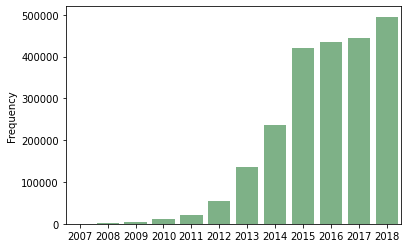

In [86]:
plot=sns.countplot(x=df.issue_ty, color='#76B982')
plot.set_xlabel(None)
plot.set_ylabel('Frequency')

<AxesSubplot:xlabel='int_rate', ylabel='Density'>

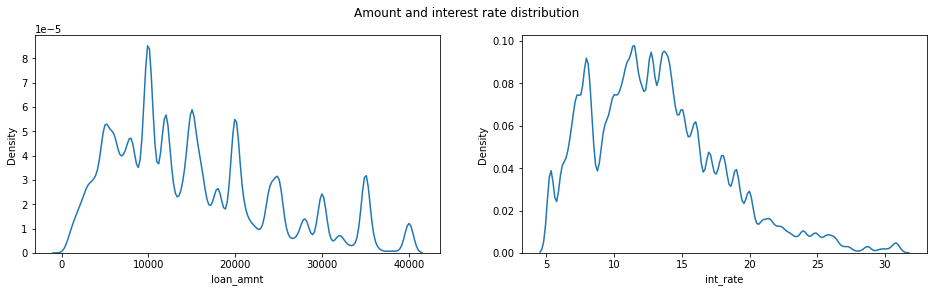

In [87]:
plot2, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4))
plot2.suptitle('Amount and interest rate distribution')
sns.kdeplot(ax=ax1, x=df.loan_amnt)
sns.kdeplot(ax=ax2, x=df.int_rate)

In [88]:
df['termM']=df['term'].str[:3].astype(int)

In [89]:
df.termM.value_counts()

36    1609754
60     650914
Name: termM, dtype: int64

# Credit Model
Target is to define a credti score model that will evaluate what is the probability a credit will be defaulte. We are going to look at the `loan_status` column to give us this information.

In [90]:
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

So interesting different values.
* `fully paid` means we have no default, although a more in depth work would check this in more detail.
* `Current` means credit is on-going and hasn't presented any problems. No Default.
* `Charged off` means credit had been sent to losses because of a default.
* etc.

To build a score we need a binary categorical approach to this variable: Defaulted Yes or No. We will regroup these categories and build a new column `default` that will represent the target of our score.

In [91]:
isdefault=['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']
df['default']=df['loan_status'].isin(isdefault)
df['default'].value_counts()

False    1969841
True      290827
Name: default, dtype: int64

In [92]:
drate=df['default'].value_counts()[True]/df.shape[0]*100
print("Default Rate: {0:.2f}%".format(drate))

Default Rate: 12.86%


The default rate is high, but we have to recall that:
* This is crowlending data, so these site attracts typically more risky clients, who had been refused credits by banks.
* This is a lifetime default value, minurs the bias form on-going credits

## Features of the score
Now we will analise

### Credit bureau risk grading
there is s

In [93]:
df['grade'].value_counts()

B    663557
C    650053
A    433027
D    324424
E    135639
F     41800
G     12168
Name: grade, dtype: int64

In [94]:
df['sub_grade'].value_counts()

C1    145903
B5    140288
B4    139793
B3    131514
C2    131116
C3    129193
C4    127115
B2    126621
B1    125341
C5    116726
A5    107617
A4     95874
A1     86790
D1     81787
A3     73184
D2     72899
A2     69562
D3     64819
D4     56896
D5     48023
E1     33573
E2     29924
E3     26708
E4     22763
E5     22671
F1     13413
F2      9305
F3      7791
F4      6124
F5      5167
G1      4106
G2      2688
G3      2094
G4      1712
G5      1568
Name: sub_grade, dtype: int64

<AxesSubplot:xlabel='default', ylabel='sub_grade'>

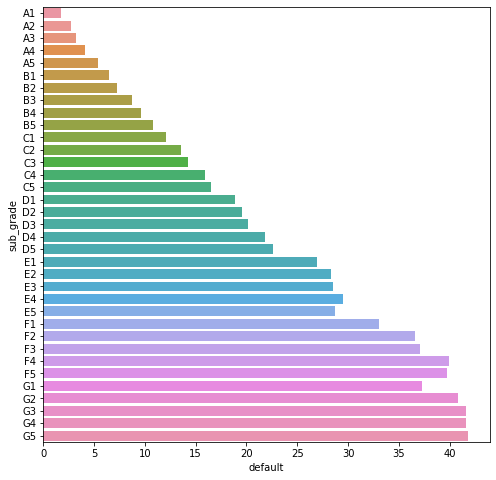

In [95]:
def_by_subgrade=(df.groupby('sub_grade')['default'].mean()*100) 
plot3, ax = plt.subplots(figsize=(8, 8))
sns.barplot(ax=ax, y=def_by_subgrade.index, x=def_by_subgrade)

In [96]:
sub_grade_list = list(df['sub_grade'].unique())
sub_grade_list.sort()
sub_grade_map = dict(zip(sub_grade_list, list(range(1,len(sub_grade_list)+1))))
print(sub_grade_map)

{'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20, 'E1': 21, 'E2': 22, 'E3': 23, 'E4': 24, 'E5': 25, 'F1': 26, 'F2': 27, 'F3': 28, 'F4': 29, 'F5': 30, 'G1': 31, 'G2': 32, 'G3': 33, 'G4': 34, 'G5': 35}


In [97]:
df['sub_grade'].sample(10)

877193     B3
241430     E2
1866300    C2
1812760    E2
1034488    C3
1156192    A1
255387     D4
877647     A1
866605     A5
1260964    C5
Name: sub_grade, dtype: object

In [98]:
df.replace({'sub_grade':sub_grade_map}, inplace=True)
df['sub_grade'].sample(10)

1844829     9
1365696     4
1786261    23
1418727    17
883446     10
269671     16
94329       7
2253109    13
151511     12
1510524    13
Name: sub_grade, dtype: int64

In [99]:
df['sub_grade'].unique()

array([14, 11,  9, 15, 26, 13,  7,  6,  2, 10, 12, 22,  4, 23,  1, 19, 28,
       16,  8, 24, 18, 17, 20,  5, 27, 21, 30, 25,  3, 32, 31, 33, 34, 29,
       35], dtype=int64)

In [100]:
features_name=[]

In [101]:
features_name.append('sub_grade')

(1.0, 2000000.0)

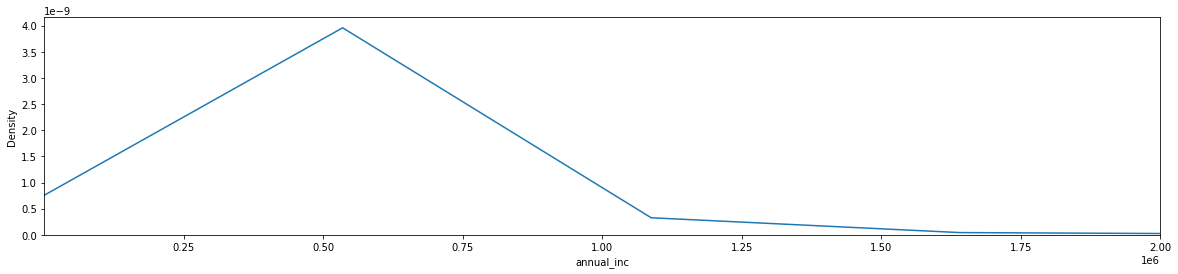

In [102]:
plot4, ax = plt.subplots(figsize=(20, 4))
sns.kdeplot(ax=ax, x=df['annual_inc'])
ax.set_xlim(1,2e6)

In [103]:
features_name.append('annual_inc')

In [104]:
df['home_ownership'].value_counts()

MORTGAGE    1111450
RENT         894929
OWN          253057
ANY             996
OTHER           182
NONE             54
Name: home_ownership, dtype: int64

In [105]:
home_ownership_values=df['home_ownership'].unique()
home_ownership_map=dict(zip(home_ownership_values,home_ownership_values)) # At this stage this is an identity map
home_ownership_map['ANY']='UNKNOWN'
home_ownership_map['OTHER']='UNKNOWN'
home_ownership_map['NONE']='UNKNOWN'
home_ownership_map

{'MORTGAGE': 'MORTGAGE',
 'RENT': 'RENT',
 'OWN': 'OWN',
 'ANY': 'UNKNOWN',
 'NONE': 'UNKNOWN',
 'OTHER': 'UNKNOWN'}

In [106]:
df.replace({'home_ownership':home_ownership_map}, inplace=True)
df['home_ownership'].value_counts()

MORTGAGE    1111450
RENT         894929
OWN          253057
UNKNOWN        1232
Name: home_ownership, dtype: int64

In [107]:
df.groupby('home_ownership')['default'].mean()*100

home_ownership
MORTGAGE    11.174952
OWN         12.885239
RENT        14.961634
UNKNOWN      9.740260
Name: default, dtype: float64

In [108]:
one_hot_home_ownership = pd.get_dummies(df['home_ownership'], prefix='home')
one_hot_home_ownership.value_counts()

home_MORTGAGE  home_OWN  home_RENT  home_UNKNOWN
1              0         0          0               1111450
0              0         1          0                894929
               1         0          0                253057
               0         0          1                  1232
dtype: int64

In [109]:
features_df=[df, one_hot_home_ownership]
features_name += list(one_hot_home_ownership.columns)

In [110]:
features_name

['sub_grade',
 'annual_inc',
 'home_MORTGAGE',
 'home_OWN',
 'home_RENT',
 'home_UNKNOWN']

### Employee title

In [111]:
df['emp_title'] = df['emp_title'].str.lower()
df['emp_title'] = df['emp_title'].replace(['rn'],'registered nurse')
emp_title=df['emp_title'].value_counts()
emp_title.index


Index(['teacher', 'manager', 'registered nurse', 'owner', 'driver',
       'supervisor', 'sales', 'office manager', 'project manager',
       'general manager',
       ...
       'intent analyst', 'associate chief judge', 'sectreary',
       'mrketing specialist', 'direct care/courier ',
       'residential nurse manager', 'special agent supervisor ',
       'relay technician principal', 'fns supervisor',
       'exec dir internal audit'],
      dtype='object', length=438349)

In [74]:
emp_title.head(25)

teacher                     46125
manager                     42822
registered nurse            36808
owner                       31740
driver                      20786
supervisor                  18560
sales                       17647
office manager              13163
project manager             12891
general manager             12111
truck driver                11144
director                     9619
president                    9032
engineer                     8498
sales manager                7872
operations manager           7486
nurse                        6864
police officer               6778
vice president               6600
store manager                6488
accountant                   6401
technician                   6034
administrative assistant     5997
attorney                     5939
account manager              5735
Name: emp_title, dtype: int64

In [112]:
tr=5000
emp_title_regrouped = emp_title[emp_title > tr]
emp_title_regrouped.index

Index(['teacher', 'manager', 'registered nurse', 'owner', 'driver',
       'supervisor', 'sales', 'office manager', 'project manager',
       'general manager', 'truck driver', 'director', 'president', 'engineer',
       'sales manager', 'operations manager', 'nurse', 'police officer',
       'vice president', 'store manager', 'accountant', 'technician',
       'administrative assistant', 'attorney', 'account manager', 'mechanic',
       'server'],
      dtype='object')

In [76]:
df[df['emp_title'].isin(emp_title_regrouped.index)].groupby('emp_title')['default'].mean()*100

emp_title
account manager             14.488636
accountant                  12.655602
administrative assistant    15.878378
attorney                     6.614786
director                    15.189873
driver                      19.699220
engineer                    14.242116
general manager             18.395303
manager                     18.059490
mechanic                    15.922865
nurse                       16.425121
office manager              14.571657
operations manager          12.835249
owner                       15.340308
police officer              12.320574
president                   14.955135
project manager             13.868613
registered nurse            12.021106
sales                       16.434469
sales manager               19.117647
server                      17.955326
store manager               19.122610
supervisor                  16.369214
teacher                     12.283323
technician                  16.591928
truck driver                19.403974
vi

In [113]:
df.loc[~df['emp_title'].isin(emp_title_regrouped.index),'emp_title']='other'

In [114]:
df['emp_title'].value_counts()

other                       1885189
teacher                       46125
manager                       42822
registered nurse              38079
owner                         31740
driver                        20786
supervisor                    18560
sales                         17647
office manager                13163
project manager               12891
general manager               12111
truck driver                  11144
director                       9619
president                      9032
engineer                       8498
sales manager                  7872
operations manager             7486
nurse                          6864
police officer                 6778
vice president                 6600
store manager                  6488
accountant                     6401
technician                     6034
administrative assistant       5997
attorney                       5939
account manager                5735
mechanic                       5695
server                      

In [115]:
one_hot_emp_title = pd.get_dummies(df['emp_title'], prefix='title')
one_hot_emp_title

,title_account manager,title_accountant,title_administrative assistant,title_attorney,title_director,title_driver,title_engineer,title_general manager,title_manager,title_mechanic,...,title_registered nurse,title_sales,title_sales manager,title_server,title_store manager,title_supervisor,title_teacher,title_technician,title_truck driver,title_vice president
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2260695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2260696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2260697,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
features_df.append(one_hot_emp_title)
features_name += list(one_hot_emp_title.columns)
features_name

['sub_grade',
 'annual_inc',
 'home_MORTGAGE',
 'home_OWN',
 'home_RENT',
 'home_UNKNOWN',
 'title_account manager',
 'title_accountant',
 'title_administrative assistant',
 'title_attorney',
 'title_director',
 'title_driver',
 'title_engineer',
 'title_general manager',
 'title_manager',
 'title_mechanic',
 'title_nurse',
 'title_office manager',
 'title_operations manager',
 'title_other',
 'title_owner',
 'title_police officer',
 'title_president',
 'title_project manager',
 'title_registered nurse',
 'title_sales',
 'title_sales manager',
 'title_server',
 'title_store manager',
 'title_supervisor',
 'title_teacher',
 'title_technician',
 'title_truck driver',
 'title_vice president']

### Employment length

In [124]:
emp_length_before = df['emp_length'].unique()
emp_length_before

array(['10+ years', '3 years', '4 years', '6 years', '1 year', '7 years',
       '8 years', '5 years', '2 years', '9 years', '< 1 year', nan],
      dtype=object)

In [125]:
emp_len_map_txt = df['emp_length'].unique()
emp_len_map_num = [10,3,4,6,1,7,8,5,2,9,0]
emp_len_map = dict(zip(emp_len_map_txt, emp_len_map_num))
emp_len_map

{'10+ years': 10,
 '3 years': 3,
 '4 years': 4,
 '6 years': 6,
 '1 year': 1,
 '7 years': 7,
 '8 years': 8,
 '5 years': 5,
 '2 years': 2,
 '9 years': 9,
 '< 1 year': 0}

In [126]:
df.replace({'emp_length':emp_len_map}, inplace=True)
df['emp_length'].value_counts()

10.0    748005
2.0     203677
0.0     189988
3.0     180753
1.0     148403
5.0     139698
4.0     136605
6.0     102628
7.0      92695
8.0      91914
9.0      79395
Name: emp_length, dtype: int64

In [127]:
features_name.append('emp_length')
features_name

['sub_grade',
 'annual_inc',
 'home_MORTGAGE',
 'home_OWN',
 'home_RENT',
 'home_UNKNOWN',
 'title_account manager',
 'title_accountant',
 'title_administrative assistant',
 'title_attorney',
 'title_director',
 'title_driver',
 'title_engineer',
 'title_general manager',
 'title_manager',
 'title_mechanic',
 'title_nurse',
 'title_office manager',
 'title_operations manager',
 'title_other',
 'title_owner',
 'title_police officer',
 'title_president',
 'title_project manager',
 'title_registered nurse',
 'title_sales',
 'title_sales manager',
 'title_server',
 'title_store manager',
 'title_supervisor',
 'title_teacher',
 'title_technician',
 'title_truck driver',
 'title_vice president',
 'emp_length']

In [129]:
features_name.append('default')

### Verification status

In [128]:
df['verification_status'].value_counts()

Source Verified    886231
Not Verified       744806
Verified           629631
Name: verification_status, dtype: int64

In [130]:
one_hot_verif_status = pd.get_dummies(df['verification_status'], prefix='verif')
one_hot_verif_status.head(10)

,verif_Not Verified,verif_Source Verified,verif_Verified
0,1,0,0
1,1,0,0
2,1,0,0
3,0,1,0
4,0,1,0
5,0,1,0
6,1,0,0
7,1,0,0
8,1,0,0
9,1,0,0


In [131]:
features_df.append(one_hot_verif_status)
features_name += list(one_hot_verif_status.columns)

In [132]:
features_name

['sub_grade',
 'annual_inc',
 'home_MORTGAGE',
 'home_OWN',
 'home_RENT',
 'home_UNKNOWN',
 'title_account manager',
 'title_accountant',
 'title_administrative assistant',
 'title_attorney',
 'title_director',
 'title_driver',
 'title_engineer',
 'title_general manager',
 'title_manager',
 'title_mechanic',
 'title_nurse',
 'title_office manager',
 'title_operations manager',
 'title_other',
 'title_owner',
 'title_police officer',
 'title_president',
 'title_project manager',
 'title_registered nurse',
 'title_sales',
 'title_sales manager',
 'title_server',
 'title_store manager',
 'title_supervisor',
 'title_teacher',
 'title_technician',
 'title_truck driver',
 'title_vice president',
 'emp_length',
 'default',
 'verif_Not Verified',
 'verif_Source Verified',
 'verif_Verified']

# Model learning

In [133]:
df_features = pd.concat(features_df, axis = 1)[features_name]
df_features.columns

Index(['sub_grade', 'annual_inc', 'home_MORTGAGE', 'home_OWN', 'home_RENT',
       'home_UNKNOWN', 'title_account manager', 'title_accountant',
       'title_administrative assistant', 'title_attorney', 'title_director',
       'title_driver', 'title_engineer', 'title_general manager',
       'title_manager', 'title_mechanic', 'title_nurse',
       'title_office manager', 'title_operations manager', 'title_other',
       'title_owner', 'title_police officer', 'title_president',
       'title_project manager', 'title_registered nurse', 'title_sales',
       'title_sales manager', 'title_server', 'title_store manager',
       'title_supervisor', 'title_teacher', 'title_technician',
       'title_truck driver', 'title_vice president', 'emp_length', 'default',
       'verif_Not Verified', 'verif_Source Verified', 'verif_Verified'],
      dtype='object')

In [134]:
df_features.sample(10)

,sub_grade,annual_inc,home_MORTGAGE,home_OWN,home_RENT,home_UNKNOWN,title_account manager,title_accountant,title_administrative assistant,title_attorney,...,title_supervisor,title_teacher,title_technician,title_truck driver,title_vice president,emp_length,default,verif_Not Verified,verif_Source Verified,verif_Verified
429946,13,38000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,10.0,False,0,0,1
1471159,1,95000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,10.0,False,0,1,0
457022,18,110000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,10.0,True,0,1,0
1727012,10,42000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,2.0,False,0,1,0
1008943,11,48000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1.0,False,0,1,0
746555,24,86028.8,0,0,1,0,0,0,0,0,...,0,0,0,0,0,5.0,False,0,0,1
382306,6,40000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,6.0,False,0,0,1
567636,4,43000.0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0.0,False,0,1,0
81826,14,60000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,7.0,False,0,0,1
1781031,28,45000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,10.0,True,0,0,1


In [136]:
missing=df_features.isna().sum()
missing

sub_grade                              0
annual_inc                             4
home_MORTGAGE                          0
home_OWN                               0
home_RENT                              0
home_UNKNOWN                           0
title_account manager                  0
title_accountant                       0
title_administrative assistant         0
title_attorney                         0
title_director                         0
title_driver                           0
title_engineer                         0
title_general manager                  0
title_manager                          0
title_mechanic                         0
title_nurse                            0
title_office manager                   0
title_operations manager               0
title_other                            0
title_owner                            0
title_police officer                   0
title_president                        0
title_project manager                  0
title_registered

In [138]:
df_features.dropna(inplace=True)

In [140]:
df_features.shape

(2113757, 39)

## Splitting dataset into training and testing subset

In [141]:
df_features.loc[:,df_features.columns != 'default']

,sub_grade,annual_inc,home_MORTGAGE,home_OWN,home_RENT,home_UNKNOWN,title_account manager,title_accountant,title_administrative assistant,title_attorney,...,title_store manager,title_supervisor,title_teacher,title_technician,title_truck driver,title_vice president,emp_length,verif_Not Verified,verif_Source Verified,verif_Verified
0,14,55000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10.0,1,0,0
1,11,65000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10.0,1,0,0
2,9,63000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,10.0,1,0,0
3,15,110000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10.0,0,1,0
4,26,104433.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,3.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260694,11,95000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,7.0,0,1,0
2260695,8,108000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,10.0,1,0,0
2260696,8,227000.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,9.0,0,0,1
2260697,14,110000.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,6.0,1,0,0


In [142]:
X_train, X_test, y_train, y_test = train_test_split(df_features.loc[:,df_features.columns != 'default'], df_features['default'], test_size=0.3)

In [143]:
X_train.shape

(1479629, 38)

In [145]:
'default' not in X_train.columns

True

## Learning the decision tree

We use the scikit leanr `DecisionTreeClassifier` algorithm, one of the most basic and simple machine learning algorithm. Let's go and train it with our trainning data.

In [146]:
clf = tree.DecisionTreeClassifier(min_samples_split=10000)
clf = clf.fit(X_train, y_train)

Let's see how this tree looks like (at leat the first 3 levels) with a builtin tree visualisation tool.

[Text(0.5, 0.9, 'sub_grade <= 13.5\ngini = 0.221\nsamples = 100.0%\nvalue = [0.874, 0.126]'),
 Text(0.25, 0.7, 'sub_grade <= 7.5\ngini = 0.151\nsamples = 66.5%\nvalue = [0.918, 0.082]'),
 Text(0.125, 0.5, 'sub_grade <= 4.5\ngini = 0.088\nsamples = 30.3%\nvalue = [0.954, 0.046]'),
 Text(0.0625, 0.3, 'sub_grade <= 3.5\ngini = 0.055\nsamples = 14.4%\nvalue = [0.971, 0.029]'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'home_MORTGAGE <= 0.5\ngini = 0.117\nsamples = 15.9%\nvalue = [0.938, 0.062]'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'sub_grade <= 10.5\ngini = 0.2\nsamples = 36.1%\nvalue = [0.887, 0.113]'),
 Text(0.3125, 0.3, 'home_RENT <= 0.5\ngini = 0.172\nsamples = 18.2%\nvalue = [0.905, 0.095]'),
 Text(0.28125, 0.1, '\n  (...)  \n'),
 Text(0.34375, 0.1, '\n  (...)  \n'),
 Text(0.4375, 0.3, 'home_RENT <= 0.5\ngini = 0.226\nsamples = 18.0%\nvalue = [0.87, 0.13]'),
 Text(0.40625, 0

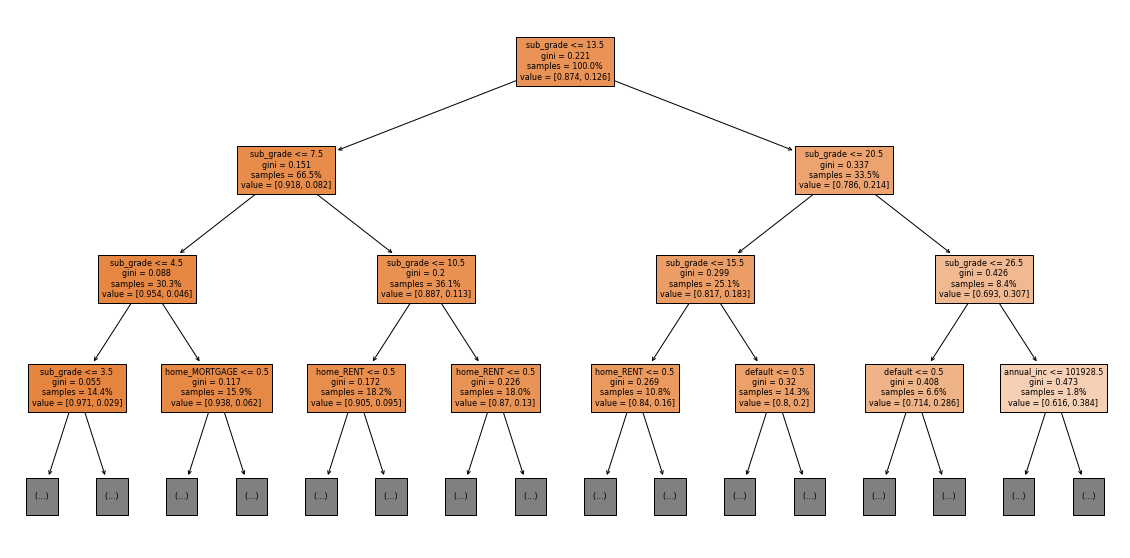

In [149]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=features_name, fontsize=8, proportion=True, filled=True, max_depth=3)

## Performance of the model
To check the performance of the model, we use the ROC curve, which gives an idea of how much we beat the random guess that will happen if we had no information.
So what is important is the AUC, or "Area Under the Curve", and expresses how much of this curve is growing steeply and quickly  towards 1. The slower it grows, the worse the prediction.

In a nutshell:
* AUC = 0.50 model is as good as a random guess.
* AUC = 0.75 average quality model
* AUC = 0.80 - 0.90 typical figures for a good model, not rare to get to these levels with good data and some time
* AUC = 1.00 Most likely you included a 1:1 variable related to the target. 

c:\Users\jjsal\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


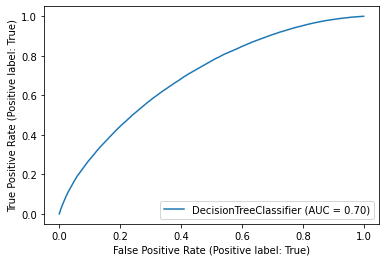

In [150]:
plot_roc_curve(clf,X_test,y_test)

In [154]:
y_pred  = clf.predict_proba(X_test)
y_pred2 = clf.predict_proba(X_train)

In [155]:
fpr, tpr, thresholds = roc_curve(y_test*1,y_pred[:,1])

In [156]:
print(roc_auc_score(y_test*1, y_pred[:,1]))

0.6978380122176957


In [157]:
print(roc_auc_score(y_train*1, y_pred2[:,1]))

0.7027562051419449
